In [30]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [31]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [32]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
# .strips()去除首尾空格
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [33]:
for filename in findFiles('data/names/*.txt'):
    # os.path.splitext(“文件路径”)    分离文件名与扩展名
    # Get the last component of the path
    category = os.path.splitext(os.path.basename(filename))[0] # 语言种类
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [34]:
print(category_lines['Chinese'][:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


In [35]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1 # tensor 默认多一维，表示batchs
    return tensor

# Turn a line into a <line_length x 1 x n_letters>
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # 要把这个batch放在中间呀
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [55]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size # 128
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # out: 185
        hidden = self.i2h(combined) # out: 128
        output = self.i2o(combined) # out: 18
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size) # (1, 128)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) # (57, 128, class_num)

In [56]:
input = letterToTensor('A') # 1 * 57
hidden = torch.zeros(1, n_hidden) # 1 * 128
output, next_hidden = rnn(input, hidden)
print(output)

torch.Size([1, 18])
tensor([[-2.8754, -3.0016, -2.9272, -2.8267, -2.8307, -2.9184, -3.0083, -2.9064,
         -2.8472, -2.8950, -2.8011, -2.8598, -2.8855, -2.9680, -2.8462, -2.8789,
         -2.9157, -2.8628]], grad_fn=<LogSoftmaxBackward>)


In [57]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

torch.Size([6, 1, 57])
torch.Size([1, 18])
tensor([[-2.8754, -3.0016, -2.9272, -2.8267, -2.8307, -2.9184, -3.0083, -2.9064,
         -2.8472, -2.8950, -2.8011, -2.8598, -2.8855, -2.9680, -2.8462, -2.8789,
         -2.9157, -2.8628]], grad_fn=<LogSoftmaxBackward>)


In [39]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # use Tensor.topk to get the index of the greatest value, 
                                  #return (values, inedx)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i # ('Russian', 14)

print(categoryFromOutput(output))

('Russian', 14)


In [59]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) #任意选择一种语言
    line = randomChoice(category_lines[category]) #在选定语言文件中任意选择一个名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long) # 类别也转化成tensor了
    line_tensor = lineToTensor(line) # [n * 1 * 57]
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

    

category = Japanese / line = Shinozaki
category = Japanese / line = Nakahara
category = English / line = Hodgson
category = Japanese / line = Hirata
category = Irish / line = Callaghan
category = Portuguese / line = Ferro
category = Italian / line = Bandini
category = Chinese / line = Lai
category = Japanese / line = Kobi
category = English / line = Snow


In [41]:
learning_rate = 0.005 # # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden  = rnn.initHidden() # torch.zeros(1, 128)
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]): # 一个字母一个字母输入的
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
       p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [42]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for printing
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
    

5000 5% (0m 20s) 2.9577 Kalbfleisch / Russian ✗ (German)
10000 10% (0m 40s) 1.6020 Ngo / Chinese ✗ (Vietnamese)
15000 15% (0m 59s) 2.8854 Elder / German ✗ (English)
20000 20% (1m 18s) 3.5265 O'Keeffe / French ✗ (Irish)
25000 25% (1m 38s) 2.2145 Patrick / French ✗ (Irish)
30000 30% (1m 57s) 0.2842 Tokuda / Japanese ✓
35000 35% (2m 17s) 0.2589 Nomikos / Greek ✓
40000 40% (2m 35s) 2.9649 Kleid / Scottish ✗ (German)
45000 45% (2m 54s) 1.0224 Paredes / Portuguese ✓
50000 50% (3m 13s) 4.4978 Chmiel / Chinese ✗ (Polish)
55000 55% (3m 31s) 1.6338 Hung / Chinese ✗ (Korean)
60000 60% (3m 51s) 2.2675 Hunter / German ✗ (Scottish)
65000 65% (4m 10s) 0.2584 Ganim / Arabic ✓
70000 70% (4m 28s) 1.8903 Huang / Vietnamese ✗ (Chinese)
75000 75% (4m 47s) 0.5924 Tokudome / Japanese ✓
80000 80% (5m 6s) 0.3343 Brunetti / Italian ✓
85000 85% (5m 25s) 2.8512 Meeuwis / Greek ✗ (Dutch)
90000 90% (5m 45s) 1.1983 Faucher / French ✓
95000 95% (6m 4s) 1.1673 Bock / Czech ✓
100000 100% (6m 22s) 1.7911 Sartre / French

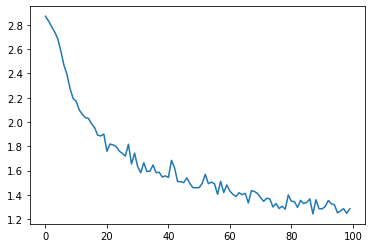

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.savefig('loss.jpg')

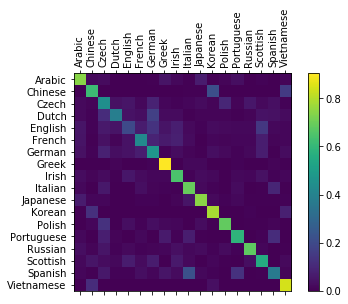

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.savefig('confusion_matrix.jpg')
plt.show()